드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/drive


라이브러리 불러오기

In [ ]:
from PIL import Image
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models import vgg16
import torch
from tqdm import tqdm
from torch.autograd import Variable

데이터셋 정의하기

In [ ]:
class AFAD_dataset(torch.nn.Module):
  def __init__(self, dir, is_train=True):
    self.dir = dir

    if is_train:
      self.images = open(os.path.join(self.dir, "train_image.txt"), "r").read().splitlines()
      self.labels = open(os.path.join(self.dir, "train_label.txt"), "r").read().splitlines()
    else:
      self.images = open(os.path.join(self.dir, "test_image.txt"), "r").read().splitlines()
      self.labels = open(os.path.join(self.dir, "test_label.txt"), "r").read().splitlines()

  def __getitem__(self, index):
    image = Image.open(os.path.join(self.dir, self.images[index]))
    label = int(self.labels[index]) - 18

    image = transforms.ToTensor()(image)
    image = transforms.Resize((224, 224))(image)

    return image, label

  def __len__(self):
    return len(self.images)


모델 정의하기

In [ ]:
class vgg_model(torch.nn.Module):
  def __init__(self):
    super(vgg_model, self).__init__()

    self.vgg = vgg16()
    self.linear = torch.nn.Sequential(
        torch.nn.Linear(1000, 22),
        torch.nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.vgg(x)
    logits = self.linear(x)
    return logits

In [ ]:
def train(model, train_loader, optimizer, criterion):
  avg_loss = 0.0
  model.train()
  for batch_idx, (img, label) in enumerate(tqdm(train_loader)):
    img = Variable(img.cuda())
    label = Variable(label.cuda().type(torch.int64))

    optimizer.zero_grad()
    output = model(img)
    loss = criterion(output, label)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()


In [ ]:
def test(model, testset):
  mae = 0
  for batch_idx, (img, label) in enumerate(tqdm(testset)):
    img = Variable(img.cuda())
    label = Variable(label.cuda().type(torch.int64))

    output = model(img)
    pred = output.argmax(dim=1)
    mae += abs(pred - label)

  return mae / len(testset)

In [ ]:
def checkpoint(model, optimizer, ckpt_path, epoch):
  torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()}, f'{ckpt_path}/Epoch{epoch:03d}.pth')

In [ ]:
def main():
  ckpt_path = "/content/drive/MyDrive/2024_MCL_Internship/AgeEstimation/checkpoints"
  if not os.path.exists(ckpt_path): os.mkdir(ckpt_path)

  trainset = AFAD_dataset("/content/drive/MyDrive/2024_MCL_Internship/AgeEstimation/dataset/AFAD-Lite", True)
  testset = AFAD_dataset("/content/drive/MyDrive/2024_MCL_Internship/AgeEstimation/dataset/AFAD-Lite", False)

  train_loader = DataLoader(dataset=trainset, batch_size=4, shuffle=True)
  test_loader = DataLoader(dataset=testset, batch_size=1, shuffle=False)

  model = vgg_model()
  model.cuda()

  optimizer = torch.optim.SGD(model.parameters(), 1e-4)

  criterion = torch.nn.CrossEntropyLoss()

  best = 20
  for epoch in range(100):
    train(model, train_loader, optimizer, criterion)

    with torch.no_grad():
      mae = test(model, test_loader)
    print("mae :", mae)
    if mae < best:
      best = mae
      checkpoint(model, optimizer, ckpt_path, epoch)


In [ ]:
main()

100%|██████████| 883/883 [05:26<00:00,  2.70it/s]


mae : tensor([7.4598], device='cuda:0')


100%|██████████| 883/883 [00:08<00:00, 101.55it/s]


mae : tensor([7.7633], device='cuda:0')


100%|██████████| 883/883 [00:08<00:00, 101.59it/s]


mae : tensor([7.4122], device='cuda:0')


100%|██████████| 883/883 [00:08<00:00, 101.77it/s]


mae : tensor([7.4666], device='cuda:0')


100%|██████████| 883/883 [00:08<00:00, 102.10it/s]


mae : tensor([7.5028], device='cuda:0')


100%|██████████| 883/883 [00:08<00:00, 101.52it/s]


mae : tensor([7.6048], device='cuda:0')


100%|██████████| 883/883 [00:08<00:00, 101.97it/s]


mae : tensor([7.5108], device='cuda:0')


100%|██████████| 883/883 [00:08<00:00, 101.43it/s]


mae : tensor([7.7712], device='cuda:0')


  4%|▎         | 33/883 [00:00<00:08, 100.35it/s]


KeyboardInterrupt: 

내 얼굴 사진으로 test해보기

In [ ]:
def shape_to_np(shape, dtype="int"):
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    return coords

from collections import OrderedDict

FACIAL_LANDMARKS_68_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))
])

# For dlib’s 5-point facial landmark detector:
FACIAL_LANDMARKS_5_IDXS = OrderedDict([
    ("right_eye", (2, 3)),
    ("left_eye", (0, 1)),
    ("nose", (4))
])

class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
                 desiredFaceWidth=256, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, gray, rect):
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = self.predictor(gray, rect)
        shape = shape_to_np(shape)

        # simple hack ;)
        if (len(shape) == 68):
            # extract the left and right eye (x, y)-coordinates
            (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
        else:
            (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]

        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]

        # compute the center of mass for each eye
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = (int((leftEyeCenter[0] + rightEyeCenter[0]) // 2),
                      int((leftEyeCenter[1] + rightEyeCenter[1]) // 2))

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
                                flags=cv2.INTER_CUBIC)

        # return the aligned face
        return output

In [ ]:
import dlib
import cv2
import matplotlib.pyplot as plt
import numpy as np

def my_image():
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/drive/MyDrive/2024_MCL_Internship/AgeEstimation/dataset/shape_predictor_68_face_landmarks.dat')
    fa = FaceAligner(predictor, desiredFaceWidth=224)

    path = "/content/drive/MyDrive/2024_MCL_Internship/AgeEstimation/face.jpg"

    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 2)

    model = vgg_model().cuda()

    checkpoint = torch.load("/content/drive/MyDrive/2024_MCL_Internship/AgeEstimation/checkpoints/Epoch002.pth")
    # model.load_state_dict(checkpoint["model_state_dict"])
    model_dict = model.state_dict()
    from collections import OrderedDict
    new_model_state_dict = OrderedDict()
    for k, v in model_dict.items():
        if k in checkpoint['model_state_dict'].keys():
            new_model_state_dict[k] = checkpoint['model_state_dict'][k]
            # print(f'Loaded\t{k}')
        else:
            new_model_state_dict[k] = v
            # print(f'Not Loaded\t{k}')

    model.load_state_dict(new_model_state_dict)

    for rect in rects:
        faceAligned = fa.align(image, gray, rect)

    model.eval()

    img = transforms.ToTensor()(faceAligned).unsqueeze(0)

    img = Variable(img.cuda())

    output = model(img)
    pred = output.argmax(dim=1)

    plt.imshow(faceAligned[..., ::-1])
    print(pred.item() + 18)

19


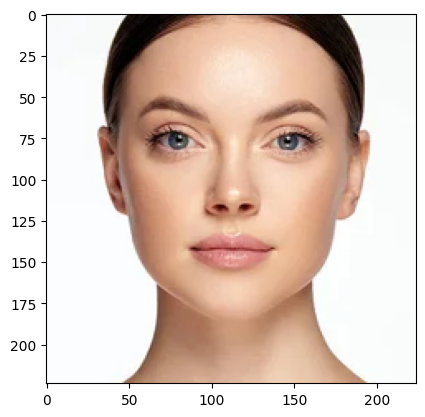

In [ ]:
my_image()